<a href="https://colab.research.google.com/github/JethinGeorge/Handwritten-Digit-Generator-/blob/main/digit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 31ms/step - kl_loss: 8.7410 - loss: 205.6922 - reconstruction_loss: 196.9512
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - kl_loss: 4.8404 - loss: 172.7845 - reconstruction_loss: 167.9441
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - kl_loss: 4.8723 - loss: 167.6813 - reconstruction_loss: 162.8090
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - kl_loss: 4.9736 - loss: 165.3580 - reconstruction_loss: 160.3844
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - kl_loss: 5.0776 - loss: 163.7554 - reconstruction_loss: 158.6778
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - kl_loss: 5.1641 - loss: 162.4548 - reconstruction_loss: 157.2907
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - kl_loss: 5.2545 - loss: 161.2519 - reconstruction_loss: 155.9974
Epoch 8/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - kl_loss: 5.3337 - loss: 160.1584 - reconstructio

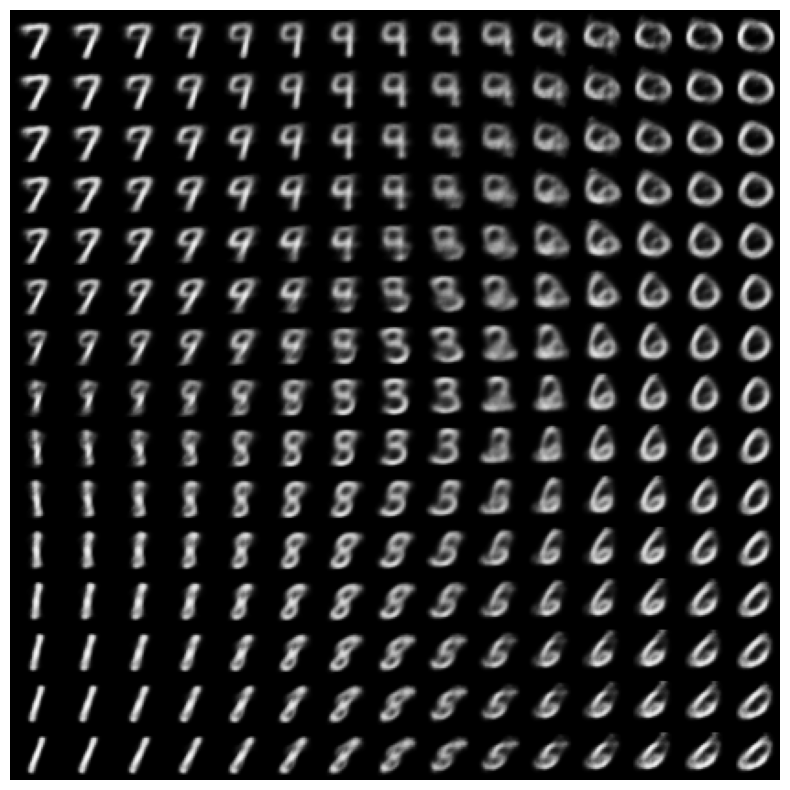

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt

(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype("float32") / 255.
x_test = x_test.astype("float32") / 255.
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

latent_dim = 2
encoder_inputs = tf.keras.Input(shape=(28, 28, 1))
x = layers.Flatten()(encoder_inputs)
x = layers.Dense(256, activation='relu')(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = tf.keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")


latent_inputs = tf.keras.Input(shape=(latent_dim,))
x = layers.Dense(256, activation='relu')(latent_inputs)
x = layers.Dense(28 * 28, activation='sigmoid')(x)
x = layers.Reshape((28, 28, 1))(x)
decoder = tf.keras.Model(latent_inputs, x, name="decoder")

class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(losses.binary_crossentropy(data, reconstruction), axis=(1, 2))
            )
            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
            )
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {"loss": total_loss, "reconstruction_loss": reconstruction_loss, "kl_loss": kl_loss}

vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam())
vae.fit(x_train, epochs=20, batch_size=128)

n = 15
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = np.linspace(-2, 2, n)
grid_y = np.linspace(-2, 2, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap="gray")
plt.axis("off")
plt.show()